# 클러스터링 분석

## K-means, GMM, Spectral, HDBSCAN 클러스터링 적용

## XAI 해석 (SHAP, LIME, Permutation Importance 적용)

### 사용할 라이브러리

In [96]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

In [97]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
# macOS에서 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스(-)가 깨질 수 있는 것을 방지함
plt.rcParams['axes.unicode_minus'] = False


In [99]:
df = pd.read_csv("csv_files/financial_data_processing_cospi200.csv")
df = df[df['기업명_그룹'] != '삼성전자']
df

,기업명_그룹,매출액,영업이익,당기순이익,자산총계,자본총계,자본금,영업활동현금흐름,이자발생부채,영업이익률,순이익률,ROE(%),ROA(%),부채비율,EPS(원),PER(배),BPS(원),PBR(배),발행주식수(보통주)
0,BGF리테일,78168.10,2353.90,1806.20,30413.75,10074.50,173.00,6499.40,3371.05,3.0045,2.3025,19.1640,6.1845,204.4665,10452.15,13.842000,58318.90,2.5360,17283906.0
1,BNK금융지주,82983.75,9329.10,7427.55,1402323.10,106667.95,16297.00,1059.20,194600.65,12.1160,9.5230,7.2460,0.5505,1212.4140,2177.75,3.688000,31087.35,0.2545,323323988.3
2,CJ,399896.75,21261.65,4553.45,459940.30,173529.85,1790.00,43187.50,182317.25,5.2905,1.1735,3.2850,1.0215,164.8735,4743.30,23.256000,157376.10,0.5830,29176998.0
3,CJ대한통운,117828.20,4457.35,2185.80,95146.65,40917.65,1141.00,6244.35,33233.10,3.7705,1.8440,5.1870,2.3095,132.5530,8222.50,18.852000,183922.25,0.6120,22812344.0
4,CJ제일제당,284474.55,14863.60,6214.55,290387.75,115612.75,819.00,20663.90,110318.45,5.2365,2.2195,6.7945,2.2100,151.2490,25676.20,16.468500,433280.45,0.7875,15054186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,현대해상,168437.95,10420.80,7558.30,476717.70,60701.60,447.00,14037.90,16655.60,6.3260,4.5935,12.1730,1.5880,746.7925,8454.75,3.715000,77333.60,0.3630,89400000.0
195,호텔신라,39464.80,361.90,-312.55,31713.35,7943.10,2000.00,1265.10,16232.85,0.8090,-0.8505,-3.0005,-0.9120,336.9375,-781.90,3.286643,20980.10,3.7785,39248121.0
196,효성중공업,40082.75,2242.65,1152.10,49684.20,13957.55,466.00,2791.35,12929.00,5.2690,2.6040,8.2110,2.2965,269.5100,11180.00,21.237749,135929.25,1.2290,9324548.0
197,효성티앤씨,77966.55,3994.95,2516.70,42602.50,15773.25,216.00,5586.25,13711.75,5.0295,3.1635,18.9360,6.5965,177.7275,45108.25,33.786000,295216.55,1.1600,4327682.0


### 데이터 불러오기

In [100]:
# 기업명을 따로 저장한 후, feature만 따로 분리함
company = df['기업명_그룹']
X_raw = df.drop(columns=["기업명_그룹"])

X_raw

,매출액,영업이익,당기순이익,자산총계,자본총계,자본금,영업활동현금흐름,이자발생부채,영업이익률,순이익률,ROE(%),ROA(%),부채비율,EPS(원),PER(배),BPS(원),PBR(배),발행주식수(보통주)
0,78168.10,2353.90,1806.20,30413.75,10074.50,173.00,6499.40,3371.05,3.0045,2.3025,19.1640,6.1845,204.4665,10452.15,13.842000,58318.90,2.5360,17283906.0
1,82983.75,9329.10,7427.55,1402323.10,106667.95,16297.00,1059.20,194600.65,12.1160,9.5230,7.2460,0.5505,1212.4140,2177.75,3.688000,31087.35,0.2545,323323988.3
2,399896.75,21261.65,4553.45,459940.30,173529.85,1790.00,43187.50,182317.25,5.2905,1.1735,3.2850,1.0215,164.8735,4743.30,23.256000,157376.10,0.5830,29176998.0
3,117828.20,4457.35,2185.80,95146.65,40917.65,1141.00,6244.35,33233.10,3.7705,1.8440,5.1870,2.3095,132.5530,8222.50,18.852000,183922.25,0.6120,22812344.0
4,284474.55,14863.60,6214.55,290387.75,115612.75,819.00,20663.90,110318.45,5.2365,2.2195,6.7945,2.2100,151.2490,25676.20,16.468500,433280.45,0.7875,15054186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,168437.95,10420.80,7558.30,476717.70,60701.60,447.00,14037.90,16655.60,6.3260,4.5935,12.1730,1.5880,746.7925,8454.75,3.715000,77333.60,0.3630,89400000.0
195,39464.80,361.90,-312.55,31713.35,7943.10,2000.00,1265.10,16232.85,0.8090,-0.8505,-3.0005,-0.9120,336.9375,-781.90,3.286643,20980.10,3.7785,39248121.0
196,40082.75,2242.65,1152.10,49684.20,13957.55,466.00,2791.35,12929.00,5.2690,2.6040,8.2110,2.2965,269.5100,11180.00,21.237749,135929.25,1.2290,9324548.0
197,77966.55,3994.95,2516.70,42602.50,15773.25,216.00,5586.25,13711.75,5.0295,3.1635,18.9360,6.5965,177.7275,45108.25,33.786000,295216.55,1.1600,4327682.0


In [101]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# X_raw에 상수항 추가 (VIF 계산을 위한 절차)
X_with_const = sm.add_constant(X_raw)

# VIF 계산
vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i)
                   for i in range(X_with_const.shape[1])]

vif_data


,Feature,VIF
0,const,5.437383
1,매출액,8.470047
2,영업이익,30.519823
3,당기순이익,28.921608
4,자산총계,6.576082
5,자본총계,17.374299
6,자본금,5.173706
7,영업활동현금흐름,4.257953
8,이자발생부채,8.986224
9,영업이익률,2.487791


### 다중공선성 제외 (VIF > 10)

In [102]:
X_raw = X_raw.drop(['영업이익', '당기순이익', '자본총계'], axis=1)

### featurer scaling 수행

In [103]:
# StandardScaler로 정규화한다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
# X_scaled 데이터를 DataFrame으로 변환
X_scaled_df = pd.DataFrame(X_scaled, columns=X_raw.columns)

# CSV 파일로 저장
X_scaled_df.to_csv("X_scaled.csv", index=False, encoding="utf-8-sig")

print("X_scaled 데이터가 'X_scaled.csv'로 저장되었습니다.")

X_scaled 데이터가 'X_scaled.csv'로 저장되었습니다.


### 클러스터링 적용 및 평가 함수 정의

In [104]:
# 클러스터링 성능 평가 함수를 정의함 
# Silhouette Score를 사용함
def evaluate_clustering(model, X, labels=None):
    if (labels is None):
        labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    return labels, score

### 최적의 K 찾기

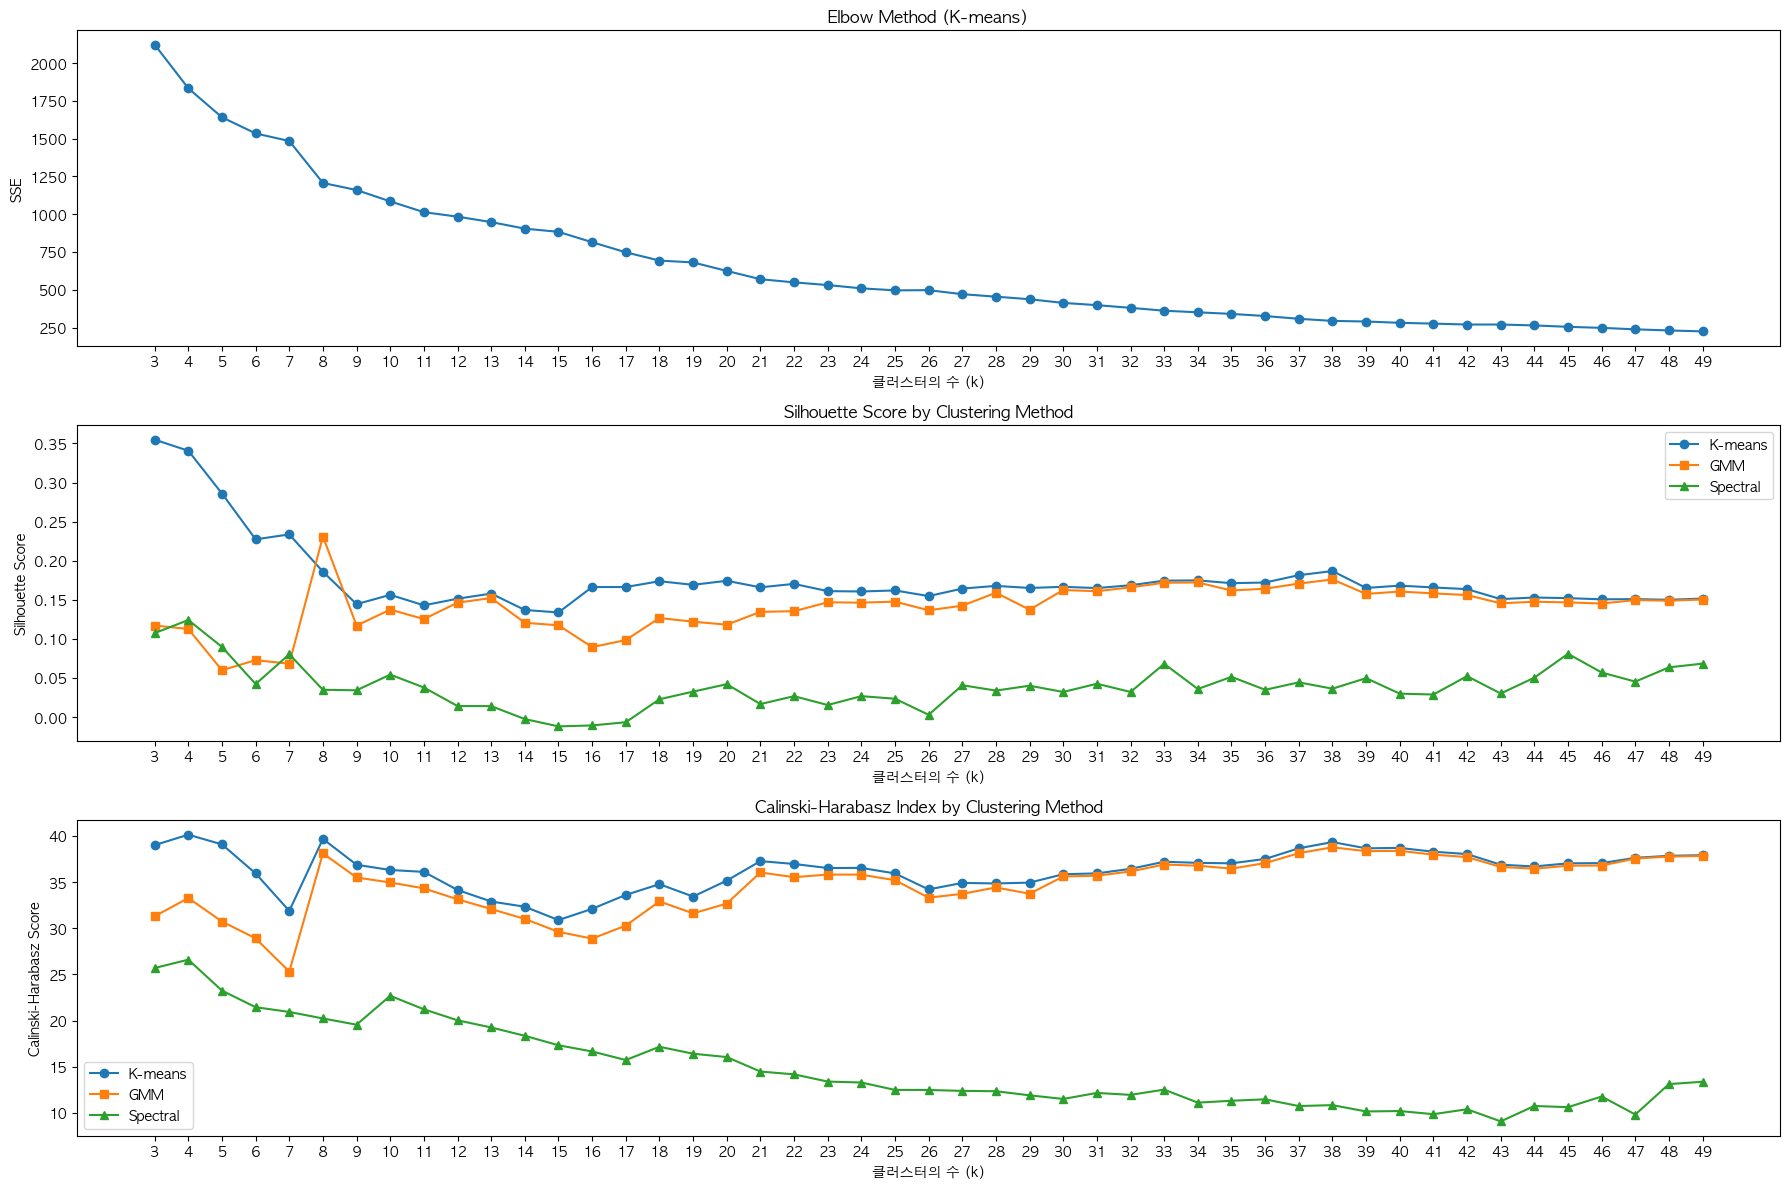

In [105]:
# 후보 K 값 범위 설정
k_values = range(3, 50)

# 결과 저장용 리스트
sse_list = [] # Elbow가 꺽이는 지점 확인용
silhouette_scores = [] # 실루엣 점수가 최대인 지점 확인용
ch_scores = [] # Calinski-Harabasz 점수가 최대인 지점 확인용

gmm_silhouette_scores = []
gmm_ch_scores = []

spectral_silhouette_scores = []
spectral_ch_scores = []

# 각 K에 대해 KMeans, GMM, Spectral 평가
for k in k_values:
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans_labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, kmeans_labels))
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)
    gmm_silhouette_scores.append(silhouette_score(X_scaled, gmm_labels))
    gmm_ch_scores.append(calinski_harabasz_score(X_scaled, gmm_labels))
    
    # Spectral clustering
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    spectral_labels = spectral.fit_predict(X_scaled)
    spectral_silhouette_scores.append(silhouette_score(X_scaled, spectral_labels))
    spectral_ch_scores.append(calinski_harabasz_score(X_scaled, spectral_labels))

plt.figure(figsize=(18, 12))

# SSE (K-means 전용)
plt.subplot(3, 1, 1)
plt.plot(k_values, sse_list, marker='o')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Elbow Method (K-means)")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("SSE")

# Silhouette Score
plt.subplot(3, 1, 2)
plt.plot(k_values, silhouette_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_silhouette_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_silhouette_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Silhouette Score by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Silhouette Score")
plt.legend()

# Calinski-Harabasz Index
plt.subplot(3, 1, 3)
plt.plot(k_values, ch_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_ch_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_ch_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Calinski-Harabasz Index by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.legend()

plt.tight_layout()
plt.show()


### K-means, GMM, Sperctral Clustering 적용 및 비교

In [114]:
# 3가지 평가 지표를 보고 k값을 결정함

# K-means clustering
# K-means는 k=5에서 가장 높은 점수를 보임
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans_labels, kmeans_score = evaluate_clustering(kmeans, X_scaled)

# GMM
# GMM은 k=7에서 가장 높은 점수를 보임
gmm = GaussianMixture(n_components=8, random_state=42)
gmm_labels, gmm_score = evaluate_clustering(gmm, X_scaled, labels=gmm.fit_predict(X_scaled))

# Spectral clustering
# Spectral clustering은 거의 모든 k의 범위에서 평가가 낮게 나옴
spectral = SpectralClustering(n_clusters=42, random_state=42, affinity='nearest_neighbors')
spectral_labels, spectral_score = evaluate_clustering(spectral, X_scaled)


# Davies-Bouldin Index 계산
# 보통 0.5 ~ 1.0 사이면 괜찮은 클러스터링이라고 함. 실무에서 자주 나오는 수준
kmeans_dbi = davies_bouldin_score(X_scaled, kmeans_labels)
gmm_dbi = davies_bouldin_score(X_scaled, gmm_labels)
spectral_dbi = davies_bouldin_score(X_scaled, spectral_labels)

# 결과 비교 출력
print(f"KMeans Davies-Bouldin Index: {kmeans_dbi:.4f}")
print(f"GMM Davies-Bouldin Index: {gmm_dbi:.4f}")
print(f"Spectral Davies-Bouldin Index: {spectral_dbi:.4f}")

# # 결과 비교
# print(f"KMeans Silhouette Score: {kmeans_score:.4f}")
# print(f"GMM Silhouette Score: {gmm_score:.4f}")
# print(f"Spectral Silhouette Score: {spectral_score:.4f}")


KMeans Davies-Bouldin Index: 1.1231
GMM Davies-Bouldin Index: 1.1608
Spectral Davies-Bouldin Index: 1.2970


### 최종적으로 선택한 클러스터 결과 저장 (K-means)

In [115]:
# K-means가 0.8356로 값이 가장 낮게 나왔다.
df['Cluster'] = kmeans_labels

### Random Forest 학습 - XAI 해석용

In [116]:
# RandomForestClassifier 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators은 기본값으로 사용함
clf.fit(X_scaled, kmeans_labels)

RandomForestClassifier(random_state=42)

### SHAP 해석

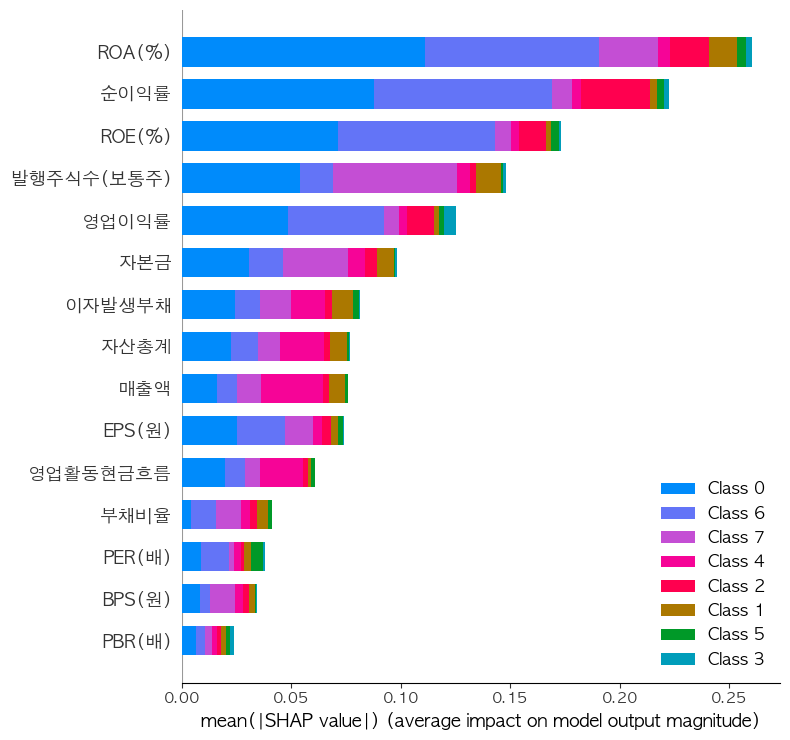

In [117]:
# SHAP 분석
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_scaled)

# feature importance를 시각화함
shap.summary_plot(shap_values, X_raw, plot_type="bar")

In [118]:
# X_raw는 DataFrame, shap_values는 클래스별 리스트 구조라고 가정
feature_names = X_raw.columns
num_classes = len(shap_values)
top_n = 5

for class_idx in range(num_classes):
    print(f"\n🟩 Class {class_idx}에서 가장 중요한 Feature TOP {top_n}:\n" + "-"*50)
    
    # 클래스별 SHAP 절댓값 평균 계산
    class_shap = np.abs(shap_values[class_idx]).mean(axis=0)
    
    # 중요도 순으로 정렬
    top_idx = np.argsort(class_shap)[::-1][:top_n]
    
    for i in top_idx:
        print(f"{feature_names[i]}: 평균 SHAP = {class_shap[i]:.4f}")


🟩 Class 0에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
매출액: 평균 SHAP = 0.0303
순이익률: 평균 SHAP = 0.0193
ROE(%): 평균 SHAP = 0.0069
이자발생부채: 평균 SHAP = 0.0049
자본금: 평균 SHAP = 0.0039

🟩 Class 1에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
ROE(%): 평균 SHAP = 0.0574
매출액: 평균 SHAP = 0.0452
순이익률: 평균 SHAP = 0.0255
자산총계: 평균 SHAP = 0.0148
이자발생부채: 평균 SHAP = 0.0123

🟩 Class 2에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
순이익률: 평균 SHAP = 0.0470
매출액: 평균 SHAP = 0.0419
ROE(%): 평균 SHAP = 0.0154
이자발생부채: 평균 SHAP = 0.0150
자산총계: 평균 SHAP = 0.0049

🟩 Class 3에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
매출액: 평균 SHAP = 0.0240
순이익률: 평균 SHAP = 0.0163
ROE(%): 평균 SHAP = 0.0078
이자발생부채: 평균 SHAP = 0.0059
자본금: 평균 SHAP = 0.0038

🟩 Class 4에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
매출액: 평균 SHAP = 0.0290
순이익률: 평균 SHAP = 0.0165
ROE(%): 평균 SHAP = 0.0088
자본금: 평균 SHAP = 0.0043
이자발생부채: 

### 위에 결과를 보면 각 class 별로 잘 주요한 feature가 나온 것을 확인할 수 있다.

### 각 cluster에 어떤 종목이 포함되어 있는지 확인

In [119]:
# 클러스터별 기업 리스트를 출력한다.
for cluster_id in range(kmeans.n_clusters):
    print(f"[클러스터 {cluster_id}에 속한 종목들]:")
    stock_list = company[kmeans_labels == cluster_id].values
    print(", ".join(stock_list))


[클러스터 0에 속한 종목들]:
BGF리테일, CJ대한통운, CJ제일제당, DB손해보험, DL, DL이앤씨, GS, HD현대인프라코어, HD현대일렉트릭, HS효성첨단소재, KCC, KT&G, LG, LG생활건강, LG이노텍, LIG넥스원, LS, LS ELECTRIC, LX인터내셔널, OCI, OCI홀딩스, PI첨단소재, S-Oil, SK바이오사이언스, SK아이이테크놀로지, SK케미칼, SK텔레콤, TCC스틸, TKG휴켐스, 강원랜드, 고려아연, 금호석유화학, 농심, 대상, 대웅, 대웅제약, 더블유게임즈, 덴티움, 동서, 동원시스템즈, 두산밥캣, 롯데정밀화학, 롯데칠성, 메리츠금융지주, 미스토홀딩스, 미원상사, 삼성E&A, 삼성SDI, 삼성물산, 삼성바이오로직스, 삼성에스디에스, 삼성전기, 삼성증권, 삼성카드, 삼성화재, 삼양식품, 세방전지, 세아제강지주, 셀트리온, 신세계, 씨에스윈드, 아모레퍼시픽, 아모레퍼시픽홀딩스, 에스엘, 에스원, 엔씨소프트, 영원무역, 영원무역홀딩스, 오뚜기, 오리온, 오리온홀딩스, 유한양행, 이수스페셜티케미컬, 제일기획, 종근당, 코스맥스, 코스모신소재, 코웨이, 키움증권, 포스코DX, 포스코인터내셔널, 풍산, 하이브, 하이트진로, 한국금융지주, 한국앤컴퍼니, 한국콜마, 한국타이어앤테크놀로지, 한국항공우주, 한미사이언스, 한미약품, 한세실업, 한솔케미칼, 한일시멘트, 한전KPS, 한전기술, 한화시스템, 한화에어로스페이스, 현대글로비스, 현대로템, 현대엘리베이터, 현대해상, 효성중공업, 효성티앤씨
[클러스터 1에 속한 종목들]:
KB금융, 기업은행, 신한지주, 우리금융지주, 하나금융지주, 한국전력
[클러스터 2에 속한 종목들]:
F&F, HMM, NAVER, SK바이오팜, SK스퀘어, 에스디바이오센서, 에이피알, 크래프톤, 한미반도체, 한진칼
[클러스터 3에 속한 종목들]:
태광산업
[클러스터 4에 속한 종목들]:
HD현대, LG전자, LG화학, POSCO홀딩스, SK, SK이노베이션, SK하이닉스, 기아, 한화, 현대모비스, 현대차

### K-means 클러스터링 결과에 종목명을 포함해서 시각화

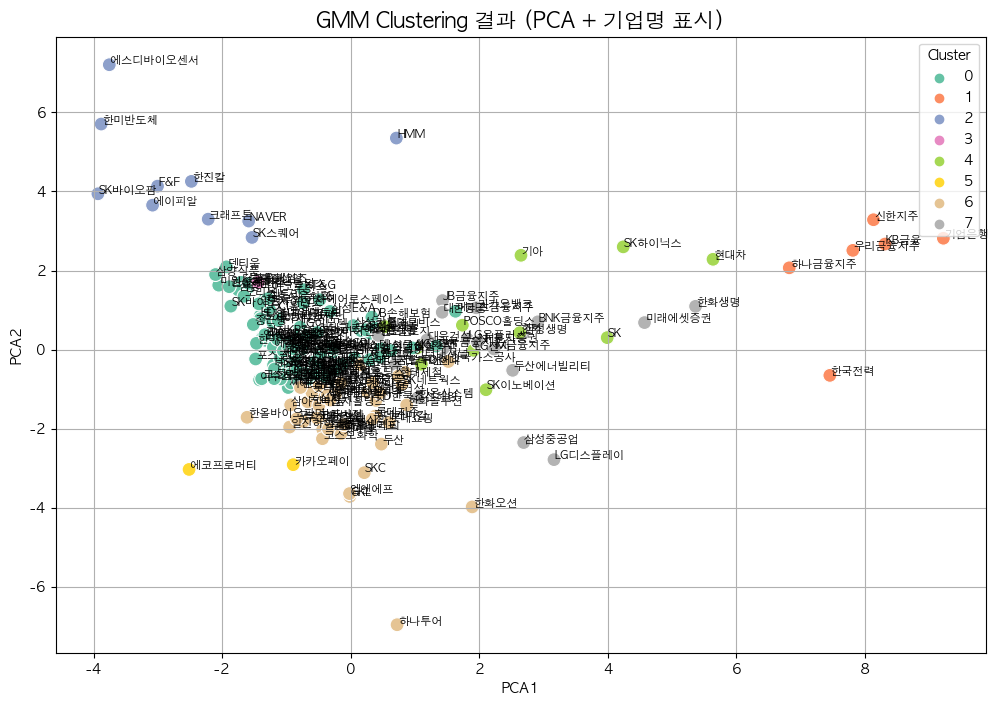

In [112]:
# 시각화를 위해 PCA로 차원을 축소한다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 결과를 dataFrame으로 정리한다. 
df_clustered = pd.DataFrame({
    '기업명': company.values,
    'Cluster': kmeans_labels,
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1]
})

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['PCA1'][i]+0.01, df_clustered['PCA2'][i]+0.01, df_clustered['기업명'][i], fontsize=8)
plt.title("GMM Clustering 결과 (PCA + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [113]:
for cluster_id in range(kmeans.n_clusters):
    stock_list = company[kmeans_labels == cluster_id].values
    print(f"[클러스터 {cluster_id}에 속한 종목들] ({len(stock_list)}개):")
    print(", ".join(stock_list))


[클러스터 0에 속한 종목들] (104개):
BGF리테일, CJ대한통운, CJ제일제당, DB손해보험, DL, DL이앤씨, GS, HD현대인프라코어, HD현대일렉트릭, HS효성첨단소재, KCC, KT&G, LG, LG생활건강, LG이노텍, LIG넥스원, LS, LS ELECTRIC, LX인터내셔널, OCI, OCI홀딩스, PI첨단소재, S-Oil, SK바이오사이언스, SK아이이테크놀로지, SK케미칼, SK텔레콤, TCC스틸, TKG휴켐스, 강원랜드, 고려아연, 금호석유화학, 농심, 대상, 대웅, 대웅제약, 더블유게임즈, 덴티움, 동서, 동원시스템즈, 두산밥캣, 롯데정밀화학, 롯데칠성, 메리츠금융지주, 미스토홀딩스, 미원상사, 삼성E&A, 삼성SDI, 삼성물산, 삼성바이오로직스, 삼성에스디에스, 삼성전기, 삼성증권, 삼성카드, 삼성화재, 삼양식품, 세방전지, 세아제강지주, 셀트리온, 신세계, 씨에스윈드, 아모레퍼시픽, 아모레퍼시픽홀딩스, 에스엘, 에스원, 엔씨소프트, 영원무역, 영원무역홀딩스, 오뚜기, 오리온, 오리온홀딩스, 유한양행, 이수스페셜티케미컬, 제일기획, 종근당, 코스맥스, 코스모신소재, 코웨이, 키움증권, 포스코DX, 포스코인터내셔널, 풍산, 하이브, 하이트진로, 한국금융지주, 한국앤컴퍼니, 한국콜마, 한국타이어앤테크놀로지, 한국항공우주, 한미사이언스, 한미약품, 한세실업, 한솔케미칼, 한일시멘트, 한전KPS, 한전기술, 한화시스템, 한화에어로스페이스, 현대글로비스, 현대로템, 현대엘리베이터, 현대해상, 효성중공업, 효성티앤씨
[클러스터 1에 속한 종목들] (6개):
KB금융, 기업은행, 신한지주, 우리금융지주, 하나금융지주, 한국전력
[클러스터 2에 속한 종목들] (10개):
F&F, HMM, NAVER, SK바이오팜, SK스퀘어, 에스디바이오센서, 에이피알, 크래프톤, 한미반도체, 한진칼
[클러스터 3에 속한 종목들] (1개):
태광산업
[클러스터 4에 속한 종목들] (11개):
HD현대, LG전자, LG화학, POSCO홀딩스, SK, SK이노베이